<a href="https://colab.research.google.com/github/Nacho2904/orga_de_datos/blob/main/tp3_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 Parte II: Baseline

Del análisis exploratorio de la parte I hemos aprendido algunas cosas:
- Hay algunas columnas que no nos aportan información. En particular *did* tiene utilidad por no estar en la mayoría de columnas. El *artist_name* no debería proporcionar demasiada información al modelo teniendo en cuenta que tenemos su número de canciones y sus géneros predilectos.

- Algunas columnas requieren preprocessing. Las tres columnas de texto que tenemos, *track-name*, *lyrics* y *artist*, no pueden ser usadas directamente. *mode* y *key*, por otro lado, son features categóricas. *a_genres* también es una variable categórica que contiene varias clases. Luego hay que preprocesar las features de texto para crear nuevos features útiles, y preprocesar las features categóricas para poder utilizarlas en la regresión logística.

- No tenemos suficientes observaciones para algunos de los posibles valores del target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import top_k_accuracy_score
from google.colab import drive 
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import functools

drive.mount('/content/gdrive')
path_a_training_set = 'gdrive/MyDrive/TP3 dataset music/train.parquet'
path_a_test_set = 'gdrive/MyDrive/TP3 dataset music/test.parquet'


df_music_train = pd.read_parquet(path_a_training_set)
df_music_test = pd.read_parquet(path_a_test_set)

Mounted at /content/gdrive


In [2]:
df_music_train_filtered = df_music_train.drop(labels=["did"], axis=1)
df_music_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31383 entries, 0 to 34336
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        31383 non-null  object 
 1   lyric             31380 non-null  object 
 2   genre             31383 non-null  object 
 3   language          24021 non-null  object 
 4   popularity        31383 non-null  int64  
 5   artist            31383 non-null  object 
 6   a_genres          31383 non-null  object 
 7   a_songs           31383 non-null  float64
 8   a_popularity      31383 non-null  float64
 9   s-label           7004 non-null   float64
 10  acousticness      31383 non-null  float64
 11  danceability      31383 non-null  float64
 12  duration_ms       31383 non-null  int64  
 13  energy            31383 non-null  float64
 14  instrumentalness  31383 non-null  float64
 15  key               31383 non-null  object 
 16  liveness          31383 non-null  float6

## Preprocessing

En primer lugar notamos que las variables categóricas *key* y *time-signature* ambas son ordinales. La primera representa el tono dominante en la canción., y tomaremos el orden dado en [este blog](https://viva.pressbooks.pub/openmusictheory/chapter/pitch-and-pitch-class/). El *time-signature* es una medida de la cantidad de pulsos por unidad, y también está ordenado naturalmente. *Mode* es una variable binaria así que la encodeamos como 0 y 1.

Para las letras de los se me ocurre aplicar algo de NLP para realizar sentiment analysis.

In [3]:
nltk.download('vader_lexicon')
def apply_sentiment_analysis_to_lyrics(df_music: pd.DataFrame) -> pd.DataFrame:
  sia = SentimentIntensityAnalyzer()
  negative, neutral, positive, compound = 0, 1, 2, 3
  sentimentAnalysisOfLyrics = df_music["lyric"].map(lambda lyric: list(sia.polarity_scores(lyric).values()))
  negativeScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[negative])
  positiveScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[positive])
  neutralScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[neutral])
  compoundScoreOfLyrics = sentimentAnalysisOfLyrics.map(lambda row: row[compound])
  return pd.DataFrame(pd.concat([negativeScoreOfLyrics, positiveScoreOfLyrics,neutralScoreOfLyrics,compoundScoreOfLyrics], axis = 1))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Otra cosa que se me ocurre es usar la suma del tf-idf para medir qué tan "rico" es el vocabulario de una canción: La idea es que canciones de géneros como el pop que son más masivos y apuntan a un público general tendrán una suma de tf-idf alto, mientras que géneros como la música alternativa deberían usar un vocabulario más "peculiar".

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

genres = list(df_music_train["genre"].unique())
def get_vectorizers_by_genre(df_music: pd.DataFrame) -> dict:
  df_music_lyric_tokenized = df_music.copy().fillna("")
  df_music_lyric_tokenized["lyric"] = df_music_lyric_tokenized["lyric"].map(lambda lyric: set(nltk.word_tokenize(lyric)))
  df_music_grouped_by_genre = df_music_lyric_tokenized[["genre", "lyric"]].groupby('genre').agg(lambda x: functools.reduce(set.union, x)).reset_index()
  vocabs = dict(zip(df_music_grouped_by_genre.genre.to_list(), df_music_grouped_by_genre.lyric.to_list()))
  stopwords = set(nltk.corpus.stopwords.words("english")).union(set(nltk.corpus.stopwords.words("spanish"))).union(set(nltk.corpus.stopwords.words("french")))
  vectorizers = {genre: TfidfVectorizer(input = "content", stop_words = stopwords, vocabulary = vocabs[genre]) for genre in genres}
  for genre in genres:
    vectorizers[genre].fit(df_music[df_music["genre"] == genre]["genre"])
  return vectorizers

vectorizers = get_vectorizers_by_genre(df_music_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [5]:
def get_sum_tfidf_from_lyrics(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music = df_music.fillna("")
  column_names = ["sum_tfidf_for_" + genre.lower() for genre in genres]
  for i in range(0, len(genres)):
    df_music[column_names[i]] = np.sum(vectorizers[genres[i]].transform(df_music["lyric"]), axis = 1)
  return df_music[column_names]

get_sum_tfidf_from_lyrics(df_music_train).columns

Index(['sum_tfidf_for_dance', 'sum_tfidf_for_pop', 'sum_tfidf_for_r&b',
       'sum_tfidf_for_hip-hop', 'sum_tfidf_for_rap', 'sum_tfidf_for_soul',
       'sum_tfidf_for_rock', 'sum_tfidf_for_blues', 'sum_tfidf_for_folk',
       'sum_tfidf_for_jazz', 'sum_tfidf_for_country',
       'sum_tfidf_for_alternative', 'sum_tfidf_for_children’s music',
       'sum_tfidf_for_indie', 'sum_tfidf_for_electronic',
       'sum_tfidf_for_classical', 'sum_tfidf_for_opera', 'sum_tfidf_for_world',
       'sum_tfidf_for_ska', 'sum_tfidf_for_comedy', 'sum_tfidf_for_reggae',
       'sum_tfidf_for_reggaeton', 'sum_tfidf_for_children's music',
       'sum_tfidf_for_soundtrack', 'sum_tfidf_for_anime',
       'sum_tfidf_for_movie'],
      dtype='object')

In [6]:
def eliminate_genres_without_enough_observations(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music_recuento_filas_por_genero = df_music.groupby("genre").count().reset_index()[["genre", "track_name"]].rename(
    columns = {"track_name": "rowCount"}).sort_values("rowCount")
  problematic_genres = list(df_music_recuento_filas_por_genero[df_music_recuento_filas_por_genero["rowCount"] < 50].genre)[1:]
  return df_music[~df_music["genre"].isin(problematic_genres)]

Podemos conseguir varias features de las longitudes de los textos

In [7]:
nltk.download('punkt')
def get_length_transforms_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["number_of_lines"] = df_music["lyric"].map(lambda lyric: len(lyric.split("\n")))
  df_music["number_of_tokens"] = df_music["lyric"].map(lambda lyric: len(nltk.word_tokenize(lyric)))
  df_music["length_lyrics"] = df_music["lyric"].map(lambda lyric: len(lyric))
  df_music["length_of_track_name"] = df_music["track_name"].map(lambda track_name: len(track_name))
  return df_music[["length_lyrics", "length_of_track_name", "number_of_lines", "number_of_tokens"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Analizo las lyrics también usando [POS](https://www.guru99.com/pos-tagging-chunking-nltk.html)

In [8]:
nltk.download('averaged_perceptron_tagger')

def get_POS_vector_from_lyric_POS(lyric_POS):
  useful_pos_tags = ["FW", "JJR", "NN", "NNS", "NNP", "PDT", "PRP", "RB", "RBR",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
  POS_dictionary = {pos_tag:0 for pos_tag in useful_pos_tags}
  POS_dictionary.update({"other":0})

  for token in lyric_POS:
    if token[1] in useful_pos_tags:
      POS_dictionary[token[1]] += 1
    else:
      POS_dictionary["other"] += 1

  return [POS_dictionary[pos_tag] for pos_tag in POS_dictionary]
  

def get_POS_chunk_taggin_counts_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["lyric_POS"] = df_music["lyric"].map(lambda lyric: nltk.pos_tag(nltk.word_tokenize(lyric)))
  df_music["lyric_POS"] = df_music["lyric_POS"].map(lambda lyric_pos: get_POS_vector_from_lyric_POS(lyric_pos))
  return pd.DataFrame(df_music["lyric_POS"].to_list())


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Utilizamos un mean_encoding para language

Separamos un test de validation seleccionando diferentes artistas

In [9]:
df_music_filtered_genres = eliminate_genres_without_enough_observations(df_music_train_filtered)
artists = list(df_music_filtered_genres["artist"].unique())
train_artists = set(artists[:int(0.9*len(artists))])
validation_artists = set(artists[int(0.9*len(artists)):])
train_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(train_artists)]
validation_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(validation_artists)]

In [10]:
df_music_train_filtered.groupby("language").mean().reset_index().std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


popularity              9.838623
a_songs                46.384646
a_popularity           16.449296
s-label                      NaN
acousticness            0.187327
danceability            0.128587
duration_ms         56038.041099
energy                  0.148349
instrumentalness        0.143865
liveness                0.184033
loudness                2.047610
speechiness             0.073403
tempo                  24.384286
valence                 0.234031
dtype: float64

In [11]:
def mean_hot_encoder(df_music: pd.DataFrame, df_training: pd.DataFrame) -> pd.DataFrame:
  df_training_grouped_by_lang = df_training.groupby("language").mean().reset_index()[["language", "popularity", "a_popularity", "loudness"]]
  df_new_columns = df_music.merge(df_training_grouped_by_lang, on = "language", how = "left")
  return df_new_columns[["popularity_y", "a_popularity_y", "loudness_y"]].fillna(0)

mean_hot_encoder_using_training_set = lambda df_to_encode: mean_hot_encoder(df_to_encode, df_music_train_filtered) 

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

text_features = ["track_name", "lyric", "artist"]

numerical_features = ["a_songs", "a_popularity", "popularity", "acousticness", "danceability", "duration_ms",
                   "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]

ordinal_features = ["key", "time_signature"]

one_hot_features = ["mode"]

mean_enc_features = ["language"]

artist_genres = ["a_genres", "genre"]

label = ["genre"]

identity_transformer = preprocessing.FunctionTransformer(None)

full_processor = ColumnTransformer(transformers=[
    ('text_sentiment_analysis', preprocessing.FunctionTransformer(apply_sentiment_analysis_to_lyrics), text_features),
    ('text_tf_idf', preprocessing.FunctionTransformer(get_sum_tfidf_from_lyrics), text_features),
    ('text_simple_transforms', preprocessing.FunctionTransformer(get_length_transforms_for_text), text_features),
    ('text_POS_count', preprocessing.FunctionTransformer(get_POS_chunk_taggin_counts_for_text), text_features),
    ('mean_encoding', preprocessing.FunctionTransformer(mean_hot_encoder_using_training_set), list(df_music_train_filtered.columns)),
    ('one_hot_encoding', preprocessing.OneHotEncoder(), one_hot_features),
    ('numerical', identity_transformer, numerical_features),
    ('ordinal', preprocessing.OrdinalEncoder(categories = [['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'],
                                                            ['1/4', '3/4', '4/4', '5/4']]), ordinal_features)])

logistic_regression_pipeline = Pipeline(steps = [
    ('preprocess_X', full_processor),
    ('model', LogisticRegression(penalty='l2', C = 1, solver = "liblinear", max_iter = 500, fit_intercept = True))
])


## Regresión Logística

In [13]:
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(eliminate_genres_without_enough_observations(df_music_train_filtered)["genre"])
y_train = labelEncoder.transform(train_set["genre"])
X_train = full_processor.fit_transform(eliminate_genres_without_enough_observations(train_set).fillna(""))
#logistic_regression_pipeline.fit(train_set.fillna(""), y_train)

In [14]:
y_valid = labelEncoder.transform(validation_set["genre"])
X_validation = full_processor.transform(validation_set.fillna(""))

In [15]:
model = LogisticRegression(penalty='l1', C = 1, solver = "liblinear", max_iter = 800, fit_intercept = False)
model.fit(X_train, y_train)
preds = model.predict_proba(X_validation)
top_k_accuracy_score(y_valid, preds, k=2, labels=model.classes_)

0.5687472719336534

Nota: Antes de esta búsqueda busqué también los penalties adecuados y siempre dio que L1 era la mejor. La que muestro acá es producto de anteriores gridsearches.

In [38]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'C': hp.uniform("C", 0, 1.5),
        'penalty': hp.choice("penalty", ['l1'])}

def objective(space):

  classifier = LogisticRegression(penalty = space['penalty'], C = space['C'], solver = "liblinear",
                                  random_state = 1)
  
  classifier.fit(X_train, y_train)

  preds = classifier.predict_proba(X_validation)
  accuracy = top_k_accuracy_score(y_valid, preds, labels = classifier.classes_)
  
  print ("top_k_accuracy_score:", accuracy)
  print(classifier.get_params())

  return {'loss': -accuracy, 'status': STATUS_OK }
  
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)



top_k_accuracy_score:
0.5691837625491052
{'C': 0.6943677575260634, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
top_k_accuracy_score:
0.5735486687036229
{'C': 0.0714968115527071, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
top_k_accuracy_score:
0.571366215626364
{'C': 0.8813619000521153, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

In [40]:
best_hyperparams

{'C': 0.40577355279545824, 'penalty': 0}

In [39]:
logistic_regression_with_found_hyperparameters = LogisticRegression(penalty = 'l1', 
                                                                    C = best_hyperparams['C'], solver = "liblinear",
                                                                    random_state = 1)

In [41]:
logistic_regression_with_found_hyperparameters.fit(X_train, y_train)

LogisticRegression(C=0.40577355279545824, penalty='l1', random_state=1,
                   solver='liblinear')

In [42]:
preds = logistic_regression_with_found_hyperparameters.predict_proba(X_validation)
top_k_accuracy_score(y_valid, preds, k=2, labels=logistic_regression_with_found_hyperparameters.classes_)

0.5848974247053689

## Predicción en el test set

In [43]:
X_test = full_processor.transform(eliminate_genres_without_enough_observations(df_music_test.fillna("")))
y_test = labelEncoder.transform(eliminate_genres_without_enough_observations(df_music_test)["genre"])

In [45]:
preds = logistic_regression_with_found_hyperparameters.predict_proba(X_test)
top_k_accuracy_score(y_test, preds, k=2, labels=model.classes_)

0.5408267851042022

In [46]:
pd.DataFrame(preds).to_csv("predictions_logistic_regression.csv")

## ¿Qué features son los más importantes para predecir con el mejor modelo?

Fitteamos un decision tree al dataset para analizar las features de mayor importancia

In [47]:
df_X = pd.DataFrame(X_train)
df_X.columns = ["negativeScore", "positiveScore", "neutralScore", "compoundScore"] + ['sum_tfidf_for_dance', 'sum_tfidf_for_pop', 'sum_tfidf_for_r&b',
       'sum_tfidf_for_hip-hop', 'sum_tfidf_for_rap', 'sum_tfidf_for_soul',
       'sum_tfidf_for_rock', 'sum_tfidf_for_blues', 'sum_tfidf_for_folk',
       'sum_tfidf_for_jazz', 'sum_tfidf_for_country',
       'sum_tfidf_for_alternative', 'sum_tfidf_for_children’s music',
       'sum_tfidf_for_indie', 'sum_tfidf_for_electronic',
       'sum_tfidf_for_classical', 'sum_tfidf_for_opera', 'sum_tfidf_for_world',
       'sum_tfidf_for_ska', 'sum_tfidf_for_comedy', 'sum_tfidf_for_reggae',
       'sum_tfidf_for_reggaeton', "sum_tfidf_for_children's music",
       'sum_tfidf_for_soundtrack', 'sum_tfidf_for_anime',
       'sum_tfidf_for_movie'] + \
                  ["length_lyrics", "length_of_track_name", "number_of_lines", "number_of_tokens"] + \
                  ["FW", "JJR", "NN", "NNS", "NNP", "PDT", "PRP", "RB", "RBR",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ", "other"] + \
                  ["Minus", "Major"] + \
                  ["popularity_by_lang", "a_popularity_by_lang", "loudness_by_lang"] + numerical_features + ordinal_features


In [52]:
W = logistic_regression_with_found_hyperparameters.coef_
W = W/np.mean(W)
feature_importance = np.sum(np.abs(W), axis = 0)
feature_importance

array([1.43599912e+02, 2.04366595e+02, 1.52512489e+02, 3.83909043e+01,
       1.01149982e+02, 8.16620414e+01, 9.27754697e+01, 8.04313101e+01,
       3.88142375e+01, 7.94627666e+01, 5.73086153e+01, 9.70658685e+01,
       1.00437112e+02, 1.01959981e+02, 9.68745192e+01, 9.69371040e+01,
       5.67824889e+01, 1.00869906e+02, 7.22373854e+01, 9.63690010e+01,
       3.04814664e+01, 1.02108264e+02, 8.38201961e+01, 4.16872308e+01,
       1.18931060e+02, 1.00892298e+02, 2.84197128e+01, 5.47386861e+01,
       2.80697317e+01, 7.82364892e+01, 2.26583902e-01, 4.65103415e+00,
       3.36731034e+00, 8.20813692e-01, 6.61524336e+00, 6.52779307e+00,
       2.34769704e+00, 4.34422883e+00, 3.25007807e+00, 1.02979439e+01,
       2.51234135e+00, 2.89458197e+00, 9.98699618e+00, 7.12775249e+00,
       2.01463454e+00, 3.15711309e+00, 6.23402688e+00, 3.47697061e+00,
       5.66608911e+00, 2.99711240e+00, 7.00325697e-01, 6.25895745e+00,
       2.04711643e+01, 1.56066413e+01, 1.43537305e+02, 1.38435544e+02,
      

In [56]:
np.argsort(feature_importance)

array([61, 30, 50, 67, 33, 56, 44, 36, 40, 69, 41, 49, 45, 38, 32, 47, 37,
       31, 48, 46, 51, 35, 34, 43, 42, 39, 53, 58, 52, 65, 28, 26, 57, 20,
       70,  3,  8, 23, 64, 27, 16, 10, 18, 29,  9,  7,  5, 22,  6, 19, 14,
       15, 11, 12, 17, 25,  4, 13, 21, 24, 55, 54,  0,  2,  1, 59, 68, 62,
       63, 60, 66])

In [59]:
features = list(df_X.columns)
features_sorted_by_importance = sorted(features, key = lambda element: np.argsort(feature_importance)[features.index(element)])

In [64]:
feature_importance[np.argsort(feature_importance) < 15]

array([  6.52779307,   2.34769704,   2.89458197,   2.01463454,
         3.15711309,   6.23402688,   5.66608911,   0.7003257 ,
        20.47116429,  15.60664128,   1.05149871,  28.93712181,
       366.36376722, 391.27941514,  50.98760754])

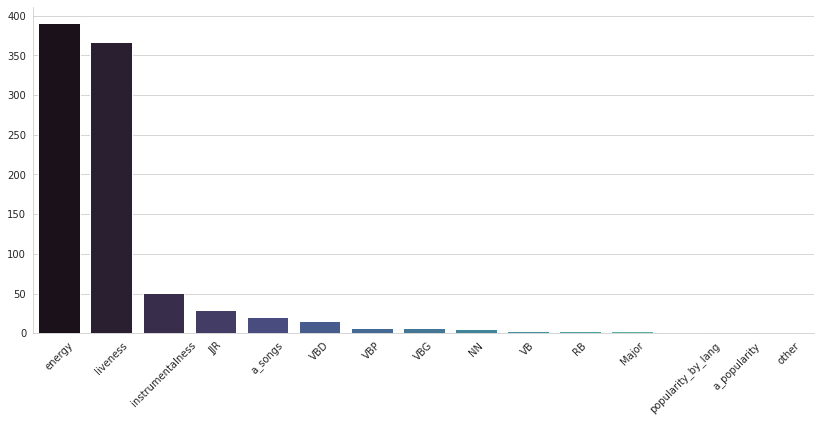

In [84]:
plt.figure(figsize = (14,6))
sns.set_style("whitegrid")
sns.barplot(x = features_sorted_by_importance[:15], y = np.sort(feature_importance[np.argsort(feature_importance) < 15])[::-1],
            order = features_sorted_by_importance[:15], palette = "mako")
plt.xticks(rotation = 45)
sns.despine();
